In [1]:
import logging
from Generator import Generator
from VertexProperty import VertexProperty
import sys
import graph_tool.all as gt
from Rule import Rule, RHS, LHS
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash
from bson import json_util
from bson.objectid import ObjectId
import csv
import argparse
from os import path
import json
import uuid
import networkx as nx
import shutil
from Metrics import MapLinearity, MissionLinearity,Leniency, PathRedundancy
import matplotlib.pyplot as plt
from os.path import isfile, join, isdir
from os import listdir, mkdir, remove
import pickle
import pandas as pd

In [2]:
def makeGraph(mongoGraph):
    g = gt.Graph()
    IDtoIndex = {}
    vertices = []
    g.vertex_properties["vertex_property"] = g.new_vertex_property("python::object")
    for i, node in enumerate(mongoGraph["nodes"]):
        v = g.add_vertex()
        IDtoIndex[node["id"]] = i
        abbrev = node["abbrev"]
        label = node["label"]
        terminality = False
        mark = node["mark"]

        vertices.append(v)
        g.vp.vertex_property[v] = VertexProperty(label, abbrev, terminality, mark)

    for edge in mongoGraph["edges"]:
        u = vertices[IDtoIndex[edge["from"]]]
        v = vertices[IDtoIndex[edge["to"]]]
        g.add_edge(u, v)
    return g


def makeGrammar(grammar):
    axiom = makeGraph(grammar["axiom"])
    # gt.graph_draw(axiom, vertex_text=abbrevs, output="img/axiom.png")

    rules = []
    for i, rule in enumerate(grammar["rules"]):
        rule_name = rule["name"]
        rule_lhs = rule["lhs"]
        lhs_graph = makeGraph(rule_lhs)
        lhs = LHS(lhs_graph)
        # gt.graph_draw(lhs_graph, vertex_text=lhs_abbrevs, output="lhs"+ str(i) +".png")
        rule_rhss = rule["rhs"]
        rhss = []
        for j, rule_rhs in enumerate(rule_rhss):
            rhs_graph = makeGraph(rule_rhs["graph"])
            rhs = RHS(rhs_graph, rule_rhs["probability"])
            rhss.append(rhs)
            # gt.graph_draw(
            #     rhs_graph, vertex_text=rhs_abbrevs, output="rhs-"  + str(i)+ "-" + str(j) + ".png"
            # )
        rules.append(Rule(rule_name, lhs, rhss, 1))

    return (axiom, rules)
safe_rooms = {"e", "g", "l", "lf", "lm", "n", "k", "kf", "km"}
non_critical_rooms = ["n", "l", "t"]

In [3]:
def hasMoreThanFour(graph):
    for v in graph.vertices():
        if len(graph.get_all_neighbors(v)) > 4:
            return True
    return False

In [4]:
def containsKM(graph):
    for v in graph.vertices():
        if graph.vp.vertex_property[v].abbrev == "km":
            return True
    return False

In [5]:
def findExit(graph):
    exit = 0
    for v in graph.vertices():
        if(graph.vp.vertex_property[v].abbrev == "g"):
            exit = v
            break
    return exit

In [6]:
def genExamples(gen, config):
    leniency = []
    map_linearity = []
    mission_linearity = []
    path_redundancy = []
    has_more_than_4 = []
    has_km= []
    sample_ids = []
    training_samples = []
    for i in range(1000):
        sample, sample_id = gen.applyRules(config)
        exit = findExit(sample)
        sample_ids.append(sample_id)
        has_more_than_4.append(hasMoreThanFour(sample))
        has_km.append(containsKM(sample))
        leni =  Leniency(sample,safe_rooms)
        mission_lin =  MissionLinearity(sample,0,exit)
        path_red =  PathRedundancy(sample,non_critical_rooms)
        map_lin = MapLinearity(sample) 
        leniency.append(leni)
        mission_linearity.append(mission_lin)
        map_linearity.append(map_lin)
        path_redundancy.append(path_red)
    data = {"Sample ID": sample_ids, "Leniency": leniency, "Mission Linearity": mission_linearity, "Map Linearity": map_linearity, "Path Redundancy": path_redundancy , "More Than Four": has_more_than_4, "Has KM": has_km}
    df = pd.DataFrame(data)
    return df

In [7]:
def cleanDir(dir_path):
    if isdir(dir_path):
        shutil.rmtree(dir_path)

In [8]:
def SaveTrainingSet(samples, grammar):
    dir_path = "../data/trees/training-set-dormans/"
    if isdir(dir_path):
        shutil.rmtree(dir_path)
    if not isdir(dir_path):
        mkdir(dir_path)
    for sample_id in samples:
        # this is really dumb we are reading a file just to dump it again
        filename = "../data/generation-trees/" + grammar + "/" + sample_id + ".pkl"
        input_file = open(filename, "rb")
        tree = pickle.load(input_file)
        tree.saveTree(dir_path + sample_id + ".pkl")

In [9]:
def SaveGraphs(samples, grammar):
    dir_path = "../data/sample-graphs/to-score/"
    if not isdir(dir_path):
        mkdir(dir_path)
    for sample_id in samples:
        # this is really dumb we are reading a file just to dump it again
#         filename = "../data/sample-graphs/" + grammar + "/" + sample_id + ".gt"
        filename = "../data/sample-graphs/" + grammar + "/" + sample_id 
        g = gt.load_graph(filename)
#         g.save(dir_path + sample_id + '.gt')
        g.save(dir_path + sample_id)

In [10]:
def drawExpRange(df, xlabel, ylabel, thresx,thresy,ax, axis = [False, False], col = 'r'):
    x = df[xlabel]
    y = df[ylabel]
    h = ax.hist2d(x,y, bins=[25,25], range=[[0,1],[0,1]])
#     ax.ylim([0,1])
    if axis[0]:
        ax.axvline(x=thresx, color= col)
    if axis[1]:
        ax.plot([thresy, thresy, thresy], color= col)
#     ax.xlim([0,1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
#     ax.colorbar()
    return h

In [11]:
with open("../data/grammars/dormans-grammar.json") as json_file:
    data = json.load(json_file)

axiom, rules = makeGrammar(data)
config = {"max_applications": 30, "sampling_method": "uniform"}
gen = Generator(axiom, rules, "dormans-grammar-2")

In [12]:
cleanDir("../data/sample-graphs/dormans-grammar2")
cleanDir("../data/generation-trees/dormans-grammar2")
# df= genExamples(gen,config)
# print(len(training_samples))
# df = pd.read_csv('original-grammar.csv')
thres1 = 0.05
thres2 = 0.05

In [13]:
csv_filename = "number_threshold_smaller.csv"
og_grammar = {"pre1": [],"pre2":[], "pre3": [], "post1": [], "post2": [], "post3": [] }
# count_df = pd.DataFrame.from_dict(og_grammar)
# count_df.to_csv(csv_filename, mode='a')
alt_df = genExamples(gen,config)

In [14]:
for i in range(100):
    config = {"max_applications": 30, "sampling_method": "uniform"}
    gen = Generator(axiom, rules, "dormans-grammar-2")
    thres11 = 0.30
    thres12 = 0.40
    cleanDir("../data/sample-graphs/dormans-grammar2")
    cleanDir("../data/generation-trees/dormans-grammar2")
    cleanDir("../data/sample-graphs/dormans-grammar-2")
    alt_df = genExamples(gen,config)
    training_samples = alt_df[alt_df["Leniency"] < thres11]["Sample ID"]
    print(len(training_samples))
    row_entry = []
    row_entry.append(len(training_samples))


    SaveTrainingSet(training_samples, "dormans-grammar-2")

    config = {"max_applications": 30, "sampling_method": "grammar"}
    gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
    sample, sample_id = gen.applyRules(config)
    gen_altered.learnParameters("../data/trees/training-set-dormans/")

    cleanDir("../data/sample-graphs/dormans-grammar-altered")
    trained_df1 = genExamples(gen_altered,config)

    thres21 = 0.04
    thres22 = 0.82
    training_samples = alt_df[alt_df["Path Redundancy"] < thres21]["Sample ID"]
    print(len(training_samples))
    row_entry.append(len(training_samples))

    SaveTrainingSet(training_samples, "dormans-grammar-2")

    config = {"max_applications": 30, "sampling_method": "grammar"}
    gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
    sample, sample_id = gen.applyRules(config)
    gen_altered.learnParameters("../data/trees/training-set-dormans/")

    cleanDir("../data/sample-graphs/dormans-grammar-altered")
    trained_df2 = genExamples(gen_altered,config)

    thres31 = 0.40
    thres32 = 0.82
    training_samples = alt_df[alt_df["Mission Linearity"] < thres31]["Sample ID"]
    print(len(training_samples))
    row_entry.append(len(training_samples))

    SaveTrainingSet(training_samples, "dormans-grammar-2")

    config = {"max_applications": 30, "sampling_method": "grammar"}
    gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
    sample, sample_id = gen.applyRules(config)
    gen_altered.learnParameters("../data/trees/training-set-dormans/")

    cleanDir("../data/sample-graphs/dormans-grammar-altered")
    trained_df3 = genExamples(gen_altered,config)

    temp1 = trained_df1[trained_df1["Leniency"] < thres11]["Sample ID"]
    temp2 = trained_df2[trained_df2["Path Redundancy"] < thres21]["Sample ID"]
    temp3 = trained_df3[trained_df3["Mission Linearity"] < thres31]["Sample ID"]
    row_entry.append(len(temp1))
    row_entry.append(len(temp2))
    row_entry.append(len(temp3))
    with open(csv_filename, 'a') as fd:
        writer = csv.writer(fd)
        writer.writerow(row_entry)

241
310
99
226
334
105
254
328
114
242
334
120
252
326
100
234
315
115
213
316
129
235
348
125
234
307
115
247
330
112
231
328
103
253
318
126
260
316
92
241
310
135
264
333
112
259
317
104
245
333
108
285
322
111
239
328
124
226
298
99
253
332
121
225
280
113
244
329
103
245
310
101
264
345
88
232
339
115
241
328
115
251
333
110
236
320
119
258
333
99
226
337
117
235
318
124
243
348
131
241
327
105
245
321
127
248
312
104
227
326
100
256
326
123
243
342
131
246
323
107
241
344
102
239
331
120
221
298
108
235
323
117
261
332
103
238
331
109
253
322
96
253
328
95
245
324
114
222
303
109
243
345
100
215
350
120
268
325
121
251
322
110
228
329
107
230
342
112
213
354
108
219
332
113
226
329
116
251
318
105
237
328
114
256
313
115
234
328
129
249
317
126
228
334
106
235
325
109
246
299
103
240
318
128
255
313
105
224
324
108
241
340
114
208
294
120
250
331
101
219
330
111
258
294
99
240
325
122
232
342
113
233
323
118
226
337
122
262
340
110
256
344
123
255
347
119
258
305
113
248
335
109


In [15]:
csv_filename = "number_threshold_larger.csv"
og_grammar = {"pre1": [],"pre2":[], "pre3": [], "post1": [], "post2": [], "post3": [] }
# count_df = pd.DataFrame.from_dict(og_grammar)
# count_df.to_csv(csv_filename, mode='a')
alt_df = genExamples(gen,config)

In [16]:
for i in range(100):
    config = {"max_applications": 30, "sampling_method": "uniform"}
    gen = Generator(axiom, rules, "dormans-grammar-2")
    thres11 = 0.30
    thres12 = 0.40
    thres11 = 0.50
    thres12 = 0.40
    cleanDir("../data/sample-graphs/dormans-grammar-2")
    alt_df = genExamples(gen,config)
    training_samples = alt_df[alt_df["Leniency"] > thres11]["Sample ID"]
    print(len(training_samples))
    row_entry = []
    row_entry.append(len(training_samples))


    SaveTrainingSet(training_samples, "dormans-grammar-2")

    config = {"max_applications": 30, "sampling_method": "grammar"}
    gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
    sample, sample_id = gen.applyRules(config)
    gen_altered.learnParameters("../data/trees/training-set-dormans/")

    cleanDir("../data/sample-graphs/dormans-grammar-altered")
    trained_df1 = genExamples(gen_altered,config)

    thres21 = 0.10
    thres22 = 0.82
    training_samples = alt_df[alt_df["Path Redundancy"] > thres21]["Sample ID"]
    print(len(training_samples))
    row_entry.append(len(training_samples))

    SaveTrainingSet(training_samples, "dormans-grammar-2")

    config = {"max_applications": 30, "sampling_method": "grammar"}
    gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
    sample, sample_id = gen.applyRules(config)
    gen_altered.learnParameters("../data/trees/training-set-dormans/")

    cleanDir("../data/sample-graphs/dormans-grammar-altered")
    trained_df2 = genExamples(gen_altered,config)

    thres31 = 0.55
    thres32 = 0.82
    training_samples = alt_df[alt_df["Mission Linearity"] > thres31]["Sample ID"]
    print(len(training_samples))
    row_entry.append(len(training_samples))

    SaveTrainingSet(training_samples, "dormans-grammar-2")

    config = {"max_applications": 30, "sampling_method": "grammar"}
    gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
    sample, sample_id = gen.applyRules(config)
    gen_altered.learnParameters("../data/trees/training-set-dormans/")

    cleanDir("../data/sample-graphs/dormans-grammar-altered")
    trained_df3 = genExamples(gen_altered,config)

    temp1 = trained_df1[trained_df1["Leniency"] > thres11]["Sample ID"]
    temp2 = trained_df2[trained_df2["Path Redundancy"] > thres21]["Sample ID"]
    temp3 = trained_df3[trained_df3["Mission Linearity"] > thres31]["Sample ID"]
    row_entry.append(len(temp1))
    row_entry.append(len(temp2))
    row_entry.append(len(temp3))
    with open(csv_filename, 'a') as fd:
        writer = csv.writer(fd)
        writer.writerow(row_entry)

112
199
150
131
190
119
112
184
103
117
189
121
128
189
133
129
158
109
113
173
118
114
179
122
109
182
110
115
174
133
118
193
127
123
176
132
121
156
141
130
199
122
127
207
132
131
165
118
122
194
133
140
194
120
104
154
115
131
184
119
127
176
119
111
180
125
123
147
121
132
179
126
120
179
119
122
156
123
122
175
113
116
167
119
121
193
144
136
206
115
145
186
123
109
168
115
101
179
103
127
193
105
122
166
117
121
188
137
128
199
123
140
214
131
135
175
117
114
157
103
132
199
108
113
184
123
132
184
121
125
195
125
124
191
128
135
204
136
139
203
126
122
189
112
118
170
133
150
196
118
110
170
115
123
180
118
136
174
131
121
193
120
131
187
135
113
178
123
120
180
130
110
160
142
137
187
121
104
172
132
128
185
124
118
174
108
112
175
140
128
181
114
113
174
121
116
183
131
123
181
118
125
182
132
118
185
119
101
149
120
114
175
111
125
175
123
145
196
118
128
164
124
124
204
134
122
187
120
122
176
110
137
180
123
124
185
118
132
189
131
119
197
115
111
170
106
125
162
109
107


In [17]:
thres11 = 0.50
thres12 = 0.40
thres21 = 0.10
thres22 = 0.40
thres31 = 0.55
thres32 = 0.40

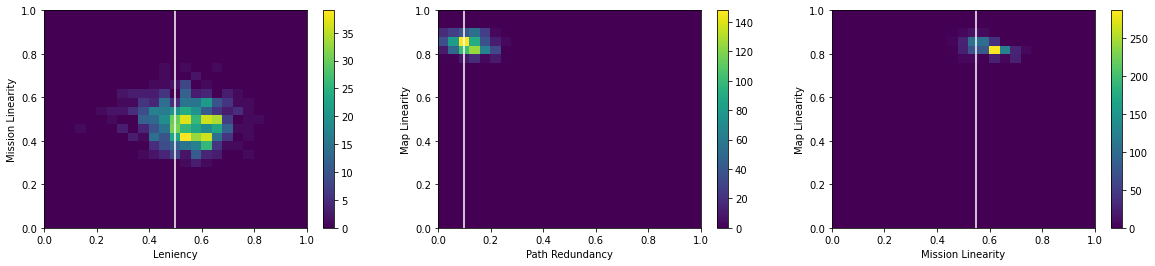

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
# fig = drawExpRange(df, 'Leniency', 'Mission Linearity',thres1, thres2,ax1 [False, False])
h1 = drawExpRange(trained_df1, 'Leniency', 'Mission Linearity',thres11, thres12,ax1, [True, False], 'w')
plt.colorbar(h1[3],ax=ax1)
h2 = drawExpRange(trained_df2, 'Path Redundancy', 'Map Linearity',thres21, thres22,ax2, [True, False], 'w')
plt.colorbar(h2[3],ax=ax2)
h3 = drawExpRange(trained_df3, 'Mission Linearity', 'Map Linearity',thres31, thres32,ax3, [True, False], 'w')
plt.colorbar(h3[3],ax=ax3)
plt.savefig("smaller-3.png")

In [19]:
# df.to_csv("original-grammar-2.csv")

In [20]:
len(temp1)

685

In [21]:
len(temp2)

561

In [22]:
len(temp3)

730